# Merchant Ranking Algorith
The method of ranking each merchant, will take inspiration from the methods proposed in (https://sapinsider.org/leveraging-analytical-method-for-ranking-suppliers/), in which we rank each key attribute out of 5, then sum them together with weightsget a score for each merchant. 

The Key Attributes for now are: 
- Revenue
- Customer_Base 
- Sustainability
- Envirnment

In [1]:
from pyspark.sql import SparkSession, functions as F
from pyspark.ml import feature as H
# First lets reed the datasets
spark = (
    SparkSession.builder.appName("Data_Explorer")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config("spark.driver.memory", "4g")
    .getOrCreate()
)

22/10/09 18:47:05 WARN Utils: Your hostname, James-N580VD-DM229T resolves to a loopback address: 127.0.1.1; using 172.27.222.219 instead (on interface eth0)
22/10/09 18:47:05 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/10/09 18:47:08 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [29]:
# Read the datasets 
transactions = spark.read.parquet('../data/processed/transactions')
merchants =  spark.read.parquet('../data/processed/merchants/')
full_dataset = spark.read.parquet('../data/curated/full_dataset_Variation/')
final_data_collection = merchants.select('merchant_abn')
fraud_probabilities = spark.read.parquet('../models/random_forest_output_full/')
fraud_probabilities = fraud_probabilities.select('merchant_abn', 'user_id', 'order_datetime', 'prediction')

In [31]:
# Define our scaliong function
def feature_standardisation(dataset, max_columns, min_columns = False): 
    for col_name in max_columns:
        values = dataset.select(F.max(col_name).alias('high'), F.min(col_name).alias('low'))
        dataset = dataset.withColumn(col_name, F.round((F.col(col_name) - values.select('low').head()[0]) / (values.select('high').head()[0] - values.select('low').head()[0]), 4))
    if min_columns != False:
        for col_name in min_columns:
            values = dataset.select(F.max(col_name).alias('high'), F.min(col_name).alias('low'))
            dataset = dataset.withColumn(col_name, F.round((values.select('high').head()[0] - F.col(col_name)) / (values.select('high').head()[0] - values.select('low').head()[0]), 4))
        return dataset

# Concerns
Just stuff i came across whilst implementing

<AxesSubplot:xlabel='dollar_value', ylabel='Count'>

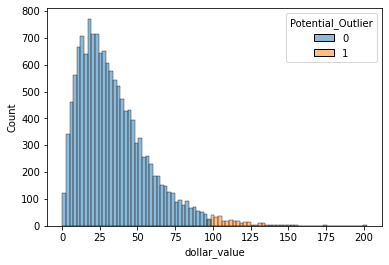

In [4]:
# Case: if we use a cut-off point for the fraud probability, and minus the dollar_value of 'fraud' transactions
concern1 = transactions.where(F.col('merchant_abn') == 83412691377).select('Potential_Outlier', 'dollar_value').toPandas()
import seaborn as sns
sns.histplot(x='dollar_value', hue='Potential_Outlier', data=concern1)
# From counting the total revenue for each merchant using such method, I found that some have negative ones (but just using outlier_attr).
# However, due to most outluiers being larger than the mean, minusing it results in devestating loss to revenue, which is to consider

# 1. Tansaction_Revenue
For this we will look into:
- Renevue (Recent)
- Projected Revenue 

In [32]:
# For revenue, we first set the break point as what we determine as 'Recent'
# We will for now determine as last 6 months (i.e march) 
RECENCY =  F.lit('2022-03-01')

1.1 Revenue

In [6]:
# take subset
revenue_data = full_dataset.where(F.col('order_datetime') > RECENCY).select('merchant_abn','user_id', 'order_datetime', 'dollar_value', 'BNPL_Revenue')

In [7]:
# Now join fraud prob 
revenue_data = revenue_data.join(fraud_probabilities, on=['merchant_abn', 'user_id', 'order_datetime'], how='left')

In [8]:
# Proper method (with the probabilities)
# revenue_data = revenue_data.withColumn('BNPL_weighted_Revenue', F.col('BNPL_Revenue') * F.col('Fraud_probability'))

In [9]:
# Alternative Method
revenue_data = revenue_data.withColumn('BNPL_weighted_Revenue', F.col('BNPL_Revenue') * (1 - 0.1 * F.col('prediction'))
                                                                 )
# save dataset for growth analysis
revenue_growth = revenue_data

In [10]:
# Now can caluculate each Merchants revenue
revenue_data = revenue_data.groupBy('merchant_abn').agg(F.round(F.sum('BNPL_weighted_Revenue'), 2).alias('Total_Revenue'))

1.2 Revenue Growth

In [12]:
# Revenye Growth
revenue_data_table = full_dataset.select('merchant_abn').distinct()
# now for the past 6 monts calculate 
months = [3,4,5,6,7,8,9]
for month in months:
    end_month = month + 1
    if end_month < 10:
        revenue_data_table = revenue_data_table.join(revenue_growth.where((F.col('order_datetime') < F.lit('2022-0' + str(end_month)+'-01'))).groupBy('merchant_abn').agg(F.sum('BNPL_weighted_Revenue').alias('Month_' + str(month))), on='merchant_abn', how='left')
    else:
        revenue_data_table = revenue_data_table.join(revenue_growth.where((F.col('order_datetime') < F.lit('2022-' + str(end_month)+'-01'))).groupBy('merchant_abn').agg(F.sum('BNPL_weighted_Revenue').alias('Month_' + str(month))), on='merchant_abn', how='left')
revenue_data_table = revenue_data_table.fillna(1)
# Now need to calculate growth rate for each month
revenue_data_table = revenue_data_table.withColumn('Growth_4', (F.col('Month_4') - F.col('Month_3')) / F.col('Month_4'))
revenue_data_table = revenue_data_table.withColumn('Growth_5', (F.col('Month_5') - F.col('Month_4')) / F.col('Month_5'))
revenue_data_table = revenue_data_table.withColumn('Growth_6', (F.col('Month_6') - F.col('Month_5')) / F.col('Month_6'))
revenue_data_table = revenue_data_table.withColumn('Growth_7', (F.col('Month_7') - F.col('Month_6'))/ F.col('Month_7'))
revenue_data_table = revenue_data_table.withColumn('Growth_8', (F.col('Month_8') - F.col('Month_7')) / F.col('Month_8'))
revenue_data_table = revenue_data_table.withColumn('Growth_9', (F.col('Month_9') - F.col('Month_8')) / F.col('Month_9'))

In [13]:
revenue_data = revenue_data.join(revenue_data_table.withColumn('Revenue_Growth_Avg', F.round((F.col('Growth_4') + F.col('Growth_5') + F.col('Growth_6') + F.col('Growth_7') + F.col('Growth_8') + F.col('Growth_9')) / 6 , 4)), on='merchant_abn', how='left')

In [14]:
# And scale
revenue_final = feature_standardisation(revenue_data, ['Revenue_Growth_Avg', 'Total_Revenue'])

In [ ]:
# save file 
revenue_final.write.parquet('../data/Normalised/revenue_scailed')

# Sustainability 
- Experience
- Customer Growth (Last 6 months)
- Postcode_Entropy
Next, we add a rating for a companies growth/longevity

In [15]:
merchants_sub = merchants.select(['merchant_abn', 'postcode_entropy'])

In [16]:
# Customer Growth
# First grab total Unique customers 
Unique_cust = full_dataset.where(F.col('order_datetime') < F.lit('2022-05-01')).groupBy('merchant_abn').agg(F.countDistinct('user_id').alias('Unique_Customers'))
# now for the past 6 monts calculate 
months = [5,6,7,8,9,10]
customer_counting_data = full_dataset.select('merchant_abn', 'user_id', 'order_datetime', 'month')
for month in months:
    end_month = month + 1
    if end_month < 10:
        Unique_cust = Unique_cust.join(customer_counting_data.where((F.col('order_datetime') < F.lit('2022-0' + str(end_month)+'-01'))).groupBy('merchant_abn').agg(F.countDistinct('user_id').alias('Month_' + str(month))), on='merchant_abn', how='left')
    else:
        Unique_cust = Unique_cust.join(customer_counting_data.where((F.col('order_datetime') < F.lit('2022-' + str(end_month)+'-01'))).groupBy('merchant_abn').agg(F.countDistinct('user_id').alias('Month_' + str(month))), on='merchant_abn', how='left')
Unique_cust = Unique_cust.fillna(1)
# Now need to calculate growth rate for each month
Unique_cust = Unique_cust.withColumn('Growth_5', F.col('Unique_Customers') / F.col('Month_5'))
Unique_cust = Unique_cust.withColumn('Growth_6', (F.col('Month_6') - F.col('Month_5')) / F.col('Month_6'))
Unique_cust = Unique_cust.withColumn('Growth_7', (F.col('Month_7') - F.col('Month_6'))/ F.col('Month_7'))
Unique_cust = Unique_cust.withColumn('Growth_8', (F.col('Month_8') - F.col('Month_7')) / F.col('Month_8'))
Unique_cust = Unique_cust.withColumn('Growth_9', (F.col('Month_9') - F.col('Month_8')) / F.col('Month_9'))
Unique_cust = Unique_cust.withColumn('Growth_10',(F.col('Month_10') - F.col('Month_9')) / F.col('Month_10'))

In [17]:
# Finally get the average customer growth rate over the last 6 months
Unique_cust = Unique_cust.withColumn('Customer_Growth_Avg', F.round((F.col('Growth_5') + F.col('Growth_6') + F.col('Growth_7') + F.col('Growth_8') + F.col('Growth_9') + F.col('Growth_10')) / 6 , 4))

In [18]:
merchants_sub = merchants_sub.join(Unique_cust.select('merchant_abn', 'Customer_Growth_Avg'), on='merchant_abn', how='left')

In [19]:
# Experience 
number_of_dates_by_merchant = transactions.groupBy('merchant_abn','order_datetime').count()
number_of_dates_by_merchant = number_of_dates_by_merchant.drop('order_datetime')
number_of_dates_by_merchant = number_of_dates_by_merchant.groupBy('merchant_abn').sum('count')
merchants_sub = merchants_sub.join(number_of_dates_by_merchant.withColumnRenamed('sum(count)','Total_Business_Days'), on='merchant_abn', how='left')

In [20]:
merchants_final = feature_standardisation(merchants_sub, ['Total_Business_Days', 'Customer_Growth_Avg'], ['postcode_entropy'])

In [ ]:
# save file 
merchants_final.write.parquet('../data/Normalised/merchant_scailed')

# Customer Base
In this sections we use the features:
- Transaction_per_User
- customer_wealth
- Unique_Customers
- Loyal_AVG
- postcode_entropy

1.1 Loyalty

In [21]:
# Create Loyalfy feature
grouped = full_dataset.groupBy("user_id", "merchant_abn")
RPR = grouped.count().withColumnRenamed("count", "RPR")
upSell = RPR.groupBy("user_id").count().withColumnRenamed("count", "upsell")
CLV = grouped.sum("dollar_value").withColumnRenamed("sum(dollar_value)", "CLV")
# Define the window
from pyspark.sql.window import Window
w = Window.partitionBy(["user_id", "merchant_abn"]).orderBy("order_datetime")

retention = full_dataset.withColumn(
    'diff',
    F.datediff(F.col("order_datetime"), F.lag("order_datetime").over(w))
).groupBy("user_id", "merchant_abn").agg(F.avg(F.col("diff")).alias("retention"))
retention.agg({"retention":"max"}).collect()
retention.na.fill(value=365)
loyal = retention.na.fill(value=365).join(RPR, on=["user_id", "merchant_abn"], how="left").join(CLV, on=["user_id", "merchant_abn"], how="left").join(upSell, on=["user_id"], how="left")
loyal = loyal.withColumn("loyal", F.col("RPR") * F.col("CLV") * F.col("upSell") / F.col("retention"))

In [22]:
from pyspark.sql.functions import col
from pyspark.sql import Window
loyal = loyal.select(*(col(c).cast("float").alias(c) for c in loyal.columns))
loyal = loyal.select('user_id', 'merchant_abn', 'loyal')

In [23]:
grp_window = Window.partitionBy('grp')
magic_percentile = F.expr('percentile_approx(loyal, 0.5)')
loyal = loyal.join(loyal.groupBy('user_id').agg(magic_percentile.alias('med_val')), on='user_id', how='left')

In [24]:
from pyspark.sql.functions import coalesce
loyal = loyal.withColumn('loyal', coalesce('loyal', 'med_val')).select(['user_id', 'merchant_abn', 'loyal'])
loyal_agg = loyal.groupBy('merchant_abn').agg(F.round(F.avg('loyal'), 2).alias('Loyal_AVG'))

Add few other metrics (Need to still add Postcode Entropy...)

In [25]:
cust_data =  full_dataset.groupBy('merchant_abn').agg(F.countDistinct('user_id').alias('Unique_Customers'), F.round(F.count('user_id') / F.countDistinct('user_id'), 2).alias('Transaction_per_User'), F.round(F.avg('Average taxable income or loss'),2).alias('customer_wealth'))
cust_data = cust_data.join(loyal_agg, on='merchant_abn')

In [26]:
# Get customer Entropy 
cust_entro = full_dataset.select('merchant_abn', 'user_id', 'electorate', 'order_datetime')
Entropy_cust = cust_entro.select('merchant_abn').toDF('merchant_abn').drop_duplicates().crossJoin(cust_entro.select('electorate').toDF('electorate').drop_duplicates())
Entropy_cust = Entropy_cust.join(cust_entro.groupBy('merchant_abn', 'electorate').agg(F.countDistinct('user_id').alias('Count')), on=['merchant_abn', 'electorate'], how='left')
Entropy_cust = Entropy_cust.fillna(1)
Entropy_cust = Entropy_cust.join(Entropy_cust.groupBy("merchant_abn").sum('Count'), on='merchant_abn', how='left')
Entropy_cust = Entropy_cust.withColumn('Probability', F.col('Count') / F.col('sum(Count)'))
Entropy_cust = Entropy_cust.groupBy("merchant_abn").agg((-F.sum(F.col("Probability") * F.log2(col("Probability")))).alias("Customer_Entropy"))

In [27]:
cust_data = cust_data.join(Entropy_cust, on='merchant_abn', how='left')
#cust_data = cust_data.join(merchants.select('merchant_abn', 'postcode_entropy'), on='merchant_abn', how='left')

In [28]:
cust_final = feature_standardisation(cust_data, ['Transaction_per_User', 'customer_wealth', 'Unique_Customers', 'Loyal_AVG'], ['Customer_Entropy'])

In [ ]:
# save file 
merchants_final.write.parquet('../data/Normalised/customer_scailed')

# Industry/Environment 
- We add a general score, based on their description tags, in relation to which industry they belong to 

In [56]:
# Read lookup table 
description_lookup = spark.read.csv('../data/tables/description_lookup.csv')
description_lookup = description_lookup.withColumnRenamed('_c0', 'Full_description')
description_lookup = description_lookup.withColumnRenamed('_c1', 'Description_Key')

In [57]:
import pandas as pd
# Next assign each to one of the 4 industries
#Administrative_Support_Services= ["equipment tool furniture appliance rent al leasing", "florist supply nursery stock flower", "lawn garden supply outlet including nursery"]
Administrative_Support_Services = [8, 10, 23]
#Personal_Services= ["shoe shop", "gift card novelty souvenir shop", "antique shop sale repair restoration service", "watch clock jewellery repair shop", "jewellery watch clock silverware shop",  "motor vehicle supply new part", "furniture home furnishing equipment shop manufa...", "tent awning shop", "optician optical good eyeglass"]
Personal_Services = [19, 5, 11, 3, 2, 12, 0, 15, 20]
#Arts_Recreation_Services = ["digital good book movie music", "music shop musical instrument piano sheet music", "health beauty spa", "bicycle shop sale service", "art dealer gallery", "hobby toy game shop", "stationery office supply printing writing paper"]
Arts_Recreation_Services = [18, 4, 21, 17, 16, 22, 14]
#Information_Media_Telecommunications = ["telecom", "computer programming data processing integrated...", "book periodical newspaper", "artist supply craft shop", "computer computer peripheral equipment software", "cable satellite pay television radio service"]
Information_Media_Telecommunications=[24, 6,7,9,1,13]
desc = []
tags = []
for ele in Administrative_Support_Services:
    desc.append("Administrative_Support_Services")
tags += Administrative_Support_Services
for ele in Personal_Services:
    desc.append("Personal_Services")
tags += Personal_Services
for ele in Arts_Recreation_Services:
    desc.append("Arts_Recreation_Services")
tags += Arts_Recreation_Services
for ele in Information_Media_Telecommunications:
    desc.append("Information_Media_Telecommunications")
tags += Information_Media_Telecommunications

to_df = {
    "sector" :  desc,
    "Description" : tags
}
sectors = spark.createDataFrame(pd.DataFrame(to_df))
dataset_sect = description_lookup.join(sectors, on= description_lookup.Description_Key == sectors.Description).drop('Description')

In [69]:
industry_data = full_dataset.select('merchant_abn','user_id', 'order_datetime', 'dollar_value', 'BNPL_Revenue', 'Description')
# Now join fraud prob 
industry_data = industry_data.join(fraud_probabilities, on=['merchant_abn', 'user_id', 'order_datetime'], how='left')
industry_data = industry_data.withColumn('BNPL_weighted_Revenue', F.col('BNPL_Revenue') * (1 - 0.1 * F.col('prediction'))
                                                                 )

In [70]:
industry_data = industry_data.join(dataset_sect, on=industry_data.Description == dataset_sect.Description_Key, how='left').drop('Full_Description', 'Description_Key')

Now we can begin getting our attributes, which are:
- Market Dominance
- Survival Rate
- Fraud_Prob_Avg
- Customer_Base
- Growth

In [112]:
# Define the toggle 
#SECTOR_SIZE = 'Description'
# or 
SECTOR_SIZE = 'sector'
Merchant_Industry = industry_data.select('merchant_abn', 'sector').distinct()

In [1]:
# Market Dominance
industry_table = industry_data.where(F.col('order_datetime') > RECENCY).groupBy('sector').agg(F.sum('BNPL_weighted_Revenue').alias('Total_Weighted_Revenue'), F.count('BNPL_weighted_Revenue').alias('Total_Transactions'), F.avg('BNPL_weighted_Revenue').alias('Average_Weighted_Revenue'))

NameError: name 'industry_data' is not defined

In [114]:
total_rev = industry_table.groupBy().sum().collect()[0][0]
total_transa = industry_table.groupBy().sum().collect()[0][0]

In [115]:
industry_table = industry_table.withColumn('Total_Weighted_Revenue', F.col('Total_Weighted_Revenue') / total_rev).withColumnRenamed('Total_Weighted_Revenue', 'Portion_of_Total_Revenue')
industry_table = industry_table.withColumn('Total_Transactions', F.col('Total_Transactions') / total_transa).withColumnRenamed('Total_Transactions', 'Portion_of_Total_Transactions')

In [116]:
# Survival Rate
sector_info = spark.read.parquet('../data/tables/sector_information/')
industry_table = industry_table.join(sector_info.select(F.col('sector'), F.col('survival_rate').cast('double').alias("survival_rate"), on='sector', how='left')

In [117]:
industry_table = feature_standardisation(industry_table, ['Portion_of_Total_Revenue', 'Portion_of_Total_Transactions', 'survival_rate', 'Average_Weighted_Revenue'])

sector,Portion_of_Total_Revenue,survival_rate
Arts_Recreation_S...,0.23351773535218873,63.8
Administrative_Su...,0.11016472791357078,58.9
Information_Media...,0.26298592372101004,59.8
Personal_Services,0.39333161301323044,65.7


In [ ]:
# save file 
industry_table.write.parquet('../data/Normalised/industry_scailed')

# Interesting fact I found about the last and first transactions for each merchant

In [ ]:
plot_2 = full_dataset.groupBy('merchant_abn').agg(F.max('order_datetime').alias('First_order'))

In [ ]:
plot_2 = plot_2.withColumn('current', F.when(F.col('First_order') >  F.lit('2022-09-01'), True).otherwise(False))

In [ ]:
plot_2.count()

4026

In [ ]:
plot_2.where(F.col('current') == True).count()

3907

In [ ]:
sns.histplot(x='First_order', data = plot_2.toPandas())

NameError: name 'sns' is not defined